In [1]:
import logging
import os
import sys

import torch
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import graphviz
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

In [2]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.4')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

In [3]:
read_fn = '../results/2023-06-05/clean_and_split_data/split/train.pkl'

In [4]:
df = pd.read_pickle(read_fn)
df.head()

,sample,drug,log(V_V0)_obs,MID_list
0,HCI-019,Docetaxel,"[-4.942608336111663, -1.1067596571631226, -0.4...","[39, 40, 41]"
1,HCI-010,Navitoclax,"[0.4929405643445782, -0.1023920347984158, -0.2...","[0, 1, 2]"
2,HCI-001,Birinapant,"[3.1268442128828946, 3.367731160065172, 2.9592...","[109, 110, 111, 112, 113]"
3,HCI-023,Vehicle,"[1.4974996594708163, 1.42052797190589, 0.92956...","[164, 165, 166, 167, 168]"
4,HCI-016,Vehicle,"[1.0749322060874602, 1.9593876186593693, 1.702...","[51, 52, 53, 54, 55, 56]"


In [5]:
def list_to_idx_dict(elems):
    d = {}
    for elt in elems:
        if elt not in d.keys():
            d[elt] = len(d.keys())
    return d

# vals: list of strings
# unique_vals: list of unique strings in vals
# Returns:
# idx: numpy array of length len(vals) such that vals = unique_vals[idx]
def get_indices(vals, unique_vals):
    d = list_to_idx_dict(unique_vals)
    idx = []
    for v in vals:
        idx.append(d[v])
    return np.array(idx)

In [6]:
# TODO: move to split / save side, since want train and test formatted the same way!
def format_for_model(df):
    df = df[['sample', 'drug', 'log(V_V0)_obs']]
    df = df.explode('log(V_V0)_obs').reset_index(drop=True)
    df = df.rename(columns={'log(V_V0)_obs': 'log(V_V0)'})
    return df
    
def get_model_inputs(df):
    samples = list(df['sample'].unique())
    drugs = list(df['drug'].unique())
    obs = torch.Tensor(df['log(V_V0)'].to_numpy(dtype=float))
    assert obs.shape[0] == len(df)
    s_idx = get_indices(list(df['sample']), samples)
    d_idx = get_indices(list(df['drug']), drugs)
    return len(samples), len(drugs), s_idx, d_idx, obs

In [29]:
# n_samp: number of samples
# n_drug: number of drugs
# obs: torch.Tensor of observations
# s_idx: numpy array where s_idx[i] is the index of the sample for the i-th observation
# d_idx: numpy array where d_idx[i] is the index of the drug for the i-th observation
def model(n_samp, n_drug, s_idx, d_idx, obs):
    # create global offset
    a_std = pyro.param('a_std', torch.Tensor([5]))
    a = pyro.sample('a', dist.Normal(torch.zeros(()), a_std * torch.ones(())))
    # create sample offset
    a_s_std = pyro.param('a_s_std', torch.Tensor([5]))
    with pyro.plate('a_s_plate', n_samp):
        a_s = pyro.sample('a_s', dist.Normal(torch.zeros(n_samp), a_s_std * torch.ones(n_samp)))
    # create drug offset
    a_d_std = pyro.param('a_d_std', torch.Tensor([5]))
    with pyro.plate('a_d_plate', n_drug):
        a_d = pyro.sample('a_d', dist.Normal(torch.zeros(n_drug), a_d_std * torch.ones(n_drug)))
    # create s
    # TODO: variance for sample plate
    s_g_alpha = pyro.param('s_g_alpha', torch.Tensor([10]))
    s_g_beta = pyro.param('s_g_beta', torch.Tensor([2]))
    with pyro.plate('s_sigma_plate', n_samp):
        s_sigma = pyro.param('s_sigma', 
                              dist.Gamma(s_g_alpha * torch.ones(n_samp), s_g_beta * torch.ones(n_samp)), 
                              constraint=constraints.positive)
    with pyro.plate('s_plate', n_samp):
        s = pyro.sample('s', dist.Normal(torch.zeros(n_samp), s_sigma))
    # create d
    # TODO: variance for drug plate
    d_g_alpha = pyro.param('d_g_alpha', torch.Tensor([10]))
    d_g_beta = pyro.param('d_g_beta', torch.Tensor([2]))
    with pyro.plate('d_sigma_plate', n_drug):
        d_sigma = pyro.param('d_sigma', 
                              dist.Gamma(d_g_alpha * torch.ones(n_drug), d_g_beta * torch.ones(n_drug)), 
                              constraint=constraints.positive)
    with pyro.plate('d_plate', n_drug):
        d = pyro.sample('d', dist.Normal(torch.zeros(n_drug), d_sigma))
    # create data
    # TODO: create variance plate
    mean = s[s_idx] * d[d_idx] + a_s[s_idx] + a_d[d_idx] + a
    with pyro.plate('data_plate', len(obs)):
        pyro.sample('data', dist.Normal(mean, 1), obs=obs)

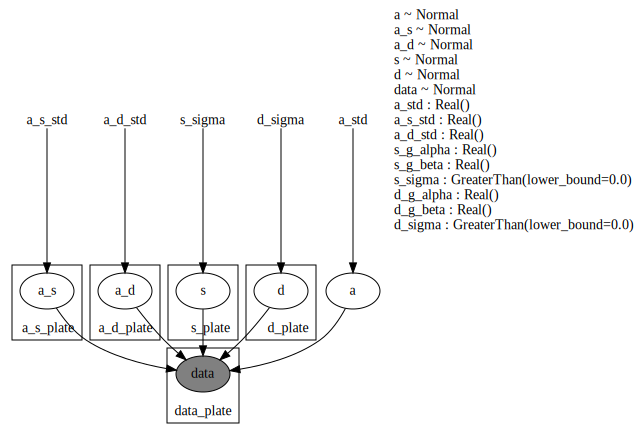

In [30]:
df = pd.read_pickle(read_fn)
df = format_for_model(df)
n_samp, n_drug, s_idx, d_idx, obs = get_model_inputs(df)
pyro.render_model(model, 
                  model_args=(n_samp, n_drug, s_idx, d_idx, obs), 
                  render_params=True, 
                  render_distributions=True)

In [12]:

m = torch.distributions.gamma.Gamma(9, 2)
m.sample()

tensor(5.3815)

In [14]:
n = dist.Gamma(9, 2)
n.sample()

tensor(4.7382)

In [ ]:
# observations: a list of pytorch tensor
# sample_indices: (num samples) x (num observations) matrix. Column i is a one-hot encoding of the sample index
# corresponding to observations[i]
# drug_indices: (num drugs) x (num observations) matrix. Column i is a one-hot encoding of the drug index
# corresponding to observations[i]
        
def model(sample_indices, drug_indices, observations):
    num_samples = sample_indices.shape[0]
    num_drugs = drug_indices.shape[0]
    num_observations = len(observations)
    assert num_observations == sample_indices.shape[1]
    assert num_observations == drug_indices.shape[1]
    # create global alpha
    alpha = pyro.sample("alpha", dist.Normal(0, 1))
    # create sample- and drug-specific alphas
    with pyro.plate("alpha_s_plate", num_samples):
        alpha_s = pyro.sample("alpha_s", dist.Normal(torch.zeros(num_samples), 1))
    with pyro.plate("alpha_d_plate", num_drugs):
        alpha_d = pyro.sample("alpha_d", dist.Normal(torch.zeros(num_drugs), 1))
    # variance for sample plate
    with pyro.plate("s_var_plate", num_samples):
        s_var = pyro.param("s_var", dist.Normal(torch.ones(num_samples) * 10, torch.ones(num_samples) * 5))
    # create sample plate
    with pyro.plate("s_plate", num_samples):
        s = pyro.sample("s", dist.Normal(torch.zeros(num_samples), s_var))
    # variance for drug plate
    with pyro.plate("d_var_plate", num_drugs):
        d_var = pyro.param("d_var", dist.Normal(torch.ones(num_drugs) * 10, torch.ones(num_drugs) * 5))
    # create drug plate
    with pyro.plate("d_plate", num_drugs):
        d = pyro.sample("d", dist.Normal(torch.zeros(num_drugs), 1))
    mean = torch.matmul(s, sample_indices) * torch.matmul(d, drug_indices)
    offset = alpha + torch.matmul(alpha_s, sample_indices) + torch.matmul(alpha_d, drug_indices)
    for i in pyro.plate("data_plate", 2):
        print(observations[i])
        pyro.sample("data" + str(i), dist.Normal(mean[i] + offset[i], 1), obs=observations[i])

pyro.render_model(model, model_args=(sample_indices, drug_indices, observations))

In [ ]:
df = pd.read_pickle(read_fn)
df.head()

In [ ]:
# Set matplotlib settings
plt.style.use('default')

df = pd.read_pickle(read_fn)
vol_name = 'log(V_V0)_obs'
sample_means = get_means(df['sample'].unique())
drug_means = get_means(df['drug'].unique())
sample_list, drug_list, obs_list = format_for_model(df, vol_name)
pyro.render_model(model, 
	model_args=(sample_list, drug_list, obs_list, sample_means, drug_means), 
	render_distributions=True)